# Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# import category_encoders as ce

# Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, auc, precision_score, recall_score, confusion_matrix

# Data

In [2]:
df_telco = pd.read_excel('Telco_customer_churn.xlsx')

In [3]:
look_var = ['Monthly Charges', 'Total Charges', 'Total Charges2']
df_telco['Total Charges2'] = df_telco['Total Charges'].astype(str)

df_telco['Total Charges Clean'] = np.where(df_telco['Total Charges']==' ', df_telco['Monthly Charges'], df_telco['Total Charges'])
df_telco['Total Charges Clean'] = df_telco['Total Charges Clean'].astype(float)

In [4]:
geos_features = ['City','Latitude', 'Longitude']
demog_features = ['Gender', 'Senior Citizen','Partner', 'Dependents','Tenure Months']
services_features = ['Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges Clean']
label = 'Churn Value'

In [5]:
df_telco[geos_features].head()

,City,Latitude,Longitude
0,Los Angeles,33.964131,-118.272783
1,Los Angeles,34.059281,-118.307420
2,Los Angeles,34.048013,-118.293953
3,Los Angeles,34.062125,-118.315709
4,Los Angeles,34.039224,-118.266293


In [6]:
df_telco[demog_features].head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months
0,Male,No,No,No,2
1,Female,No,No,Yes,2
2,Female,No,No,Yes,8
3,Female,No,Yes,Yes,28
4,Male,No,No,Yes,49


In [7]:
df_telco[services_features].head()

,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges Clean
0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
2,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50
3,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05
4,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30


# Benchmark

## Preprocessing Pipeline

In [8]:
# features selection
cat = demog_features[:-1] + services_features[:-2]
num = geos_features[1:] + demog_features[-1:] + services_features[-2:]

# ML preprocessing Pipeline
transformer = ColumnTransformer([
                                 ('one hot encoder',OneHotEncoder(drop = 'first'),cat),
                                 # ('binary encoder',binary_encoder_pipeline,['workclass','marital.status','occupation','native.country'])
                                ], remainder = 'passthrough')

# data for splitting
X = df_telco[cat + num]
y = df_telco['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, train_size = .8,random_state = 2020)

# Model Selection
model = RandomForestClassifier(random_state = 2025)
estimator = Pipeline([
                      ('preprocess',transformer),
                      ('clf',model)
])

## Model Fitting

In [9]:
estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('clf', RandomForestClassifier(random_state=2025))])

## ML Performance

In [10]:
th = 0.3

In [11]:
y_prob = estimator.predict_proba(X_test)
y_pred = np.where(y_prob[:,1] > th,1,0)

In [12]:
f1_result = f1_score(y_test, y_pred)
precision_result = precision_score(y_test, y_pred)
recall_result = recall_score(y_test, y_pred)

performance = {
    'f1':f1_result,
    'precision':precision_result,
    'recall':recall_result
}
performance

{'f1': 0.627831715210356,
 'precision': 0.5262206148282098,
 'recall': 0.7780748663101604}

## ML Performance Interpretation

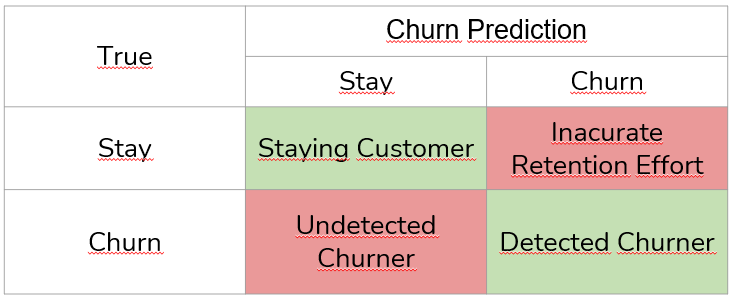

In [13]:
var_monet = ['Monthly Charges', 'Total Charges Clean']

X_monet = X_test.copy()[var_monet]
X_monet['Churn Value'] = y_test
X_monet['Churn Pred'] = y_pred

In [14]:
X_monet.head()

,Monthly Charges,Total Charges Clean,Churn Value,Churn Pred
3574,25.25,1211.65,0,0
494,72.65,1194.30,1,1
1213,70.00,70.00,1,1
1735,106.10,2249.95,1,1
3674,19.90,329.75,0,0


In [15]:
confusion_matrix = pd.crosstab(X_monet['Churn Value'],X_monet['Churn Pred'])
confusion_matrix

Churn Pred,0,1
Churn Value,,
0,773,262
1,83,291


In [16]:
undetected_churner = round(100*confusion_matrix.loc[1,0]/confusion_matrix.loc[1,:].sum(),2)
false_treatment = round(100*confusion_matrix.loc[0,1]/confusion_matrix.loc[:,1].sum(),2)

In [17]:
False_explaination = {
    'False Negative':f"It's estimated that there will be {undetected_churner}% undetected churner",
    'False Positive':f'Probably, around {false_treatment}% customer was not supposed to recive any retention treatment'
}
False_explaination

{'False Negative': "It's estimated that there will be 22.19% undetected churner",
 'False Positive': 'Probably, around 47.38% customer was not supposed to recive any retention treatment'}

### ML Performance interpretation Monetary Perspective

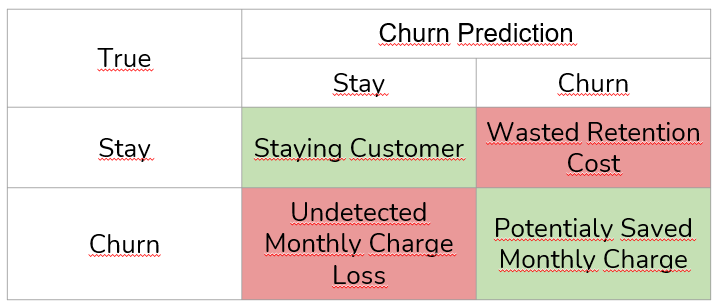

In [18]:
retention_cost = 0.05

assumption = f"""We will use monthly charge to measure monetary impact. we can derive some metrics using monthly charge, predited resul and churn value.

Secenario : Customer considered churn if churn score > {th}

Assumption:
1. result will be scaled up to intial data size
2. retention cost take up {int(retention_cost*100)}% of monthly charges
3. let's say we are doing some retention campaign. succes rate is 80%."""
print(assumption)

We will use monthly charge to measure monetary impact. we can derive some metrics using monthly charge, predited resul and churn value.

Secenario : Customer considered churn if churn score > 0.3

Assumption:
1. result will be scaled up to intial data size
2. retention cost take up 5% of monthly charges
3. let's say we are doing some retention campaign. succes rate is 80%.


## Calculation

In [19]:
scale = X_train.shape[0]/X_test.shape[0]

In [20]:
potential_monthly_charge_loss = round(scale*sum((X_monet['Churn Value'] == 1)*X_monet['Monthly Charges']))
undetected_monthly_charge_loss = round(scale*sum(((X_monet['Churn Value'] == 1) & (X_monet['Churn Pred'] == 0))*X_monet['Monthly Charges']))
wasted_retention_cost = round(scale*sum(((X_monet['Churn Value'] == 0) & (X_monet['Churn Pred'] == 1))*X_monet['Monthly Charges']*retention_cost))
potentialy_saved_monthly_charge = round(scale*sum(((X_monet['Churn Value'] == 1) & (X_monet['Churn Pred'] == 1))*X_monet['Monthly Charges']))
potentialy_saved_monthly_charge_pct = round(100*(potentialy_saved_monthly_charge - wasted_retention_cost)/ potential_monthly_charge_loss,2)

In [21]:
monetary_impact = {
    'potential monthly charge loss':potential_monthly_charge_loss,
    'undetected monthly charge loss':undetected_monthly_charge_loss,
    'wasted retention cost':wasted_retention_cost,
    'potentialy saved monthly charge':potentialy_saved_monthly_charge,
    'potentialy saved monthly charge loss (%)':potentialy_saved_monthly_charge_pct
}
monetary_impact

{'potential monthly charge loss': 112605,
 'undetected monthly charge loss': 23163,
 'wasted retention cost': 3800,
 'potentialy saved monthly charge': 89442,
 'potentialy saved monthly charge loss (%)': 76.06}

# SUMMARY

In [22]:
conclusion = f"""According to these assumption
1. result will be scaled up to intial data size
2. retention cost take up {int(retention_cost*100)}% of monthly charges
3. let's say we are doing some retention campaign. succes rate is 80%.

And scenario giving retention treatment to customers with predicted churn score > {th}.

We can save up to {potentialy_saved_monthly_charge_pct}% of potential monthly charge loss for the next period. For example, If potential loss US${potential_monthly_charge_loss} then we can save US${potentialy_saved_monthly_charge} ({potentialy_saved_monthly_charge_pct}% of potential loss)
"""

print(conclusion)

According to these assumption
1. result will be scaled up to intial data size
2. retention cost take up 5% of monthly charges
3. let's say we are doing some retention campaign. succes rate is 80%.

And scenario giving retention treatment to customers with predicted churn score > 0.3.

We can save up to 76.06% of potential monthly charge loss for the next period. For example, If potential loss US$112605 then we can save US$89442 (76.06% of potential loss)

